In [2]:
# importing the libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import chromedriver_binary
from time import sleep
from pymongo import MongoClient
import re
from selenium import webdriver
from selenium.webdriver.support.select import Select
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

%matplotlib inline

# ASSIGNMENT -1 :

## 1 ) Scraping Algorithm  :

In [196]:
# Setting up Chrome driver :

driver = webdriver.Chrome()
driver.get("https://www.imdb.com/chart/top?ref_=nv_mv_250")
driver.maximize_window()

In [141]:
# Setting up Mongodb Connection :
# Mongodb is selected to tackle issues in case, code failure arises

client = MongoClient()     # client to connect to db
db_unplan = client['Data_Science_Unplan']  # database name
collection_imdb = db_unplan['Collection_imdb_Unplan']  # collection name  

In [ ]:
# Universal loop for harvesting :

total_no_of_movies = len(driver.find_elements_by_xpath(r"//tbody[@class='lister-list']//td[@class='titleColumn']"))

for i in range(1,  total_no_of_movies + 1):  # 1 to 250
    
    dict_movie_params = {}
    
    xpath_movie_name = "//tbody[@class='lister-list']//tr[" + str(i) + "]//td[@class='titleColumn']"
    
    
    # If the movie has already been inserted into the collection then skip to the next movie :
    # This is essential to tackle code failure situations.
    # In case the code fails, then we need not scrape again for the movies which are already stored in the DB.
    
    if collection_imdb.find_one({'Name of the movie':driver.find_element_by_xpath(xpath_movie_name).text}):
#         print("already present")
        continue
    
    else:
        
        xpath_movie_link = "//tbody[@class='lister-list']//tr[" + str(i) + "]//td[@class='titleColumn']//a"
        xpath_movie_year_release = "//tbody[@class='lister-list']//tr[" + str(i) + "]//td[@class='titleColumn']//span"
        xpath_movie_rating = "//tbody[@class='lister-list']//tr[" + str(i) + "]//td[@class='ratingColumn imdbRating']//strong"
    


        # NAME OF THE MOVIE : ------------------------------

        dict_movie_params['Name of the movie'] = driver.find_element_by_xpath(xpath_movie_name).text

        # LINK : ----------------------------

        dict_movie_params['Link'] = driver.find_element_by_xpath(xpath_movie_link).get_attribute('href')

        # YEAR RELEASED : ---------------------------

        years_released = str(driver.find_element_by_xpath(xpath_movie_year_release).text)
        years_released = re.sub(r"\D", "", years_released)
        dict_movie_params['Year released'] = years_released

        # IMDB RATING : ------------------------------------

        dict_movie_params['IMDB rating'] = driver.find_element_by_xpath(xpath_movie_rating).text




        movie_link = driver.find_element_by_xpath(xpath_movie_link)
        movie_link.click()  # clicking on the current movie link name 
        sleep(5)

        xpath_movie_summary = "//div[contains(@class,'plot_summary')]//div[@class='summary_text']"
        xpath_movie_director = "//div[contains(@class,'plot_summary')]//div[@class='credit_summary_item'][1]//a"
        xpath_movie_reviewers = "//div[@class='imdbRating']//a[1]//span"
        xpath_movie_censorRating = "//div[@class='title_wrapper']//div[@class='subtext']" 
        xpath_movie_Length = "//div[@class='title_wrapper']//div[@class='subtext']//time"



        # STORY SUMMARY : ------------------------------

        dict_movie_params['story summary'] = driver.find_element_by_xpath(xpath_movie_summary).text.strip() 

        # DIRECTOR NAME : ------------------------------

        dict_movie_params['Director Name'] = driver.find_element_by_xpath(xpath_movie_director).text.strip()

        # NUMBER OF REVIEWERS : ---------------------------------

        dict_movie_params['Number of reviewers'] = driver.find_element_by_xpath(xpath_movie_reviewers).text.strip()

        # LENGTH OF MOVIES : ------------------------------------

        dict_movie_params['Length of the movie'] = driver.find_element_by_xpath(xpath_movie_Length).text.strip()

        # CENSORBOARD RATING : ---------------------------------

        censorRating = re.match(r"\w", str(driver.find_element_by_xpath(xpath_movie_censorRating).text)).group(0)
        dict_movie_params['Censor board rating'] = censorRating

        # ALL THE WRITERS : ----------------------------
        
        sleep(2)
        #         xpath_movie_writers = "//div[contains(@class, 'plot_summary')]//div[@class='credit_summary_item'][2]//a"  
        #         total_number_writers = len(driver.find_elements_by_xpath(xpath_movie_writers))  # suppose 3

        #         for n in range(1, total_number_writers + 1):
        #             dict_movie_params['Writer ' + str(n) ] = driver.find_element_by_xpath(xpath_movie_writers + "[" + str(n) + "]").text
        
        all_text_list = str(driver.find_element_by_xpath(r"//div[contains(@class, 'plot_summary')]//div[@class='credit_summary_item'][2]").text)
        all_text_list = re.sub(r"Writers\:|Writer\:", "", all_text_list)
        all_text_list = all_text_list.split(',')
        total_no_ofWriters = len(all_text_list) 
        for n in range(1, total_no_ofWriters + 1):
            dict_movie_params['Writer ' + str(n)] = all_text_list[n-1]

        # TOP 5 CAST : -----------------------------

        # a.) finding all the top 5 cast by clicking on the button 'full cast & crew':
        sleep(2)
        full_cast_crew_button = "//div[contains(@class,'plot_summary')]//div[@class='credit_summary_item'][3]//a[contains(text(),'See full cast & crew')]"
        driver.find_element_by_xpath(full_cast_crew_button).click()
        sleep(3)

        # b.) getting the first 5 stars of first 5 cast of the movie :

        for j in range(1, 6):
            xpath_cast_current = "//table[@class='cast_list']//tr[contains(@class,'even') or contains(@class,'odd')][" + str(j) + "]//td[2]//a"
            dict_movie_params['Star ' + str(j)] = driver.find_element_by_xpath(xpath_cast_current).text


        driver.back()  # Going back one page to movie details page

    
    
    # PLOT KEYWORDS : --------------------------
    
    driver.execute_script("window.scrollBy(0, 450);")
    sleep(2)
    
    xpath_movie_plot_keyword = "//div[@id='titleStoryLine']//a//span"
    plot_keywords = ""
    
    for each_plot_keyword in driver.find_elements_by_xpath(xpath_movie_plot_keyword):
        plot_keywords = plot_keywords + str(each_plot_keyword.text) + "|"
        
    dict_movie_params['Plot Keywords list'] = plot_keywords
    
    
    # BUDGET : ---------------------------------
    
    driver.execute_script("window.scrollBy(0, 500);")
    sleep(2)
    driver.find_element_by_tag_name('body').send_keys(Keys.HOME)
    driver.find_element_by_tag_name('body').send_keys(Keys.END)
    
    for each_div_texBlock in driver.find_elements_by_xpath(r"//div[@id='titleDetails']//div[@class='txt-block']"):
        if len(re.findall(r"Budget\:\s{0,1}\$\d{1,2}", str(each_div_texBlock.text))) > 0:
            break
    try:
        dict_movie_params['Budget'] = re.findall(r"Budget\:\s{0,1}(.*)",  str(each_div_texBlock.text))[0]
    except:
        dict_movie_params['Budget'] = None
            
    
    # GROSS USA : -------------------------------
    
    for each_div_texBlock in driver.find_elements_by_xpath(r"//div[@id='titleDetails']//div[@class='txt-block']"):
        if len(re.findall(r"Gross USA\:\s{0,1}\$\d{1,2}", str(each_div_texBlock.text))) > 0:
            break
            
    try:
        dict_movie_params['Gross USA'] = re.findall(r"Gross USA\:\s{0,1}(.*)", str(each_div_texBlock.text))[0]
    except:
        dict_movie_params['Gross USA'] = None
    
    
    # CUMULATIVE WORLDWIDE GROSS : -------------------------
    
    driver.find_element_by_tag_name('body').send_keys(Keys.END)
    driver.find_element_by_tag_name('body').send_keys(Keys.HOME)
    for each_div_texBlock in driver.find_elements_by_xpath(r"//div[@id='titleDetails']//div[@class='txt-block']"):
        if len(re.findall(r"Cumulative Worldwide Gross\:\s{0,1}\$\d{1,2}", str(each_div_texBlock.text))) > 0:
            break
    
    try:
        dict_movie_params['Cumulative worlwide Gross'] = re.findall(r"Cumulative Worldwide Gross\:\s{0,1}(.*)",  str(each_div_texBlock.text))[0]
    except:
        dict_movie_params['Cumulative worlwide Gross'] = None
        
        
    # PRODUCTION COMPANY : ------------------------------ 
    
    for each_div_texBlock in driver.find_elements_by_xpath(r"//div[@id='titleDetails']//div[@class='txt-block']"):
        if len(re.findall(r"Production Co\:\s{0,1}", str(each_div_texBlock.text))) > 0:
            break
    
    try:
        all_prod_comp = each_div_texBlock.text  
        all_prod_comp = re.sub(r"Production Co\:\s{0,1}", "", all_prod_comp)
        all_prod_comp = re.sub(r"See more", "", all_prod_comp)
        all_prod_comp = re.sub(r"\»", "", all_prod_comp)
        all_prod_comp = all_prod_comp.split(',')
        all_prod_comp = ', '.join(all_prod_comp)
        dict_movie_params['Production company'] = all_prod_comp

    except:
        dict_movie_params['Production company'] = None
        
    
    
    # ALL GENRES AND RELEASE DATE : ------------------------------ 
    
    driver.find_element_by_tag_name('body').send_keys(Keys.HOME)
    sleep(2)
    total_a_no = len(driver.find_elements_by_xpath(r"//div[@class='title_wrapper']//div[@class='subtext']//a")) 
    for x in range(1, total_a_no + 1):
        
        if x == total_a_no:
            dict_movie_params['Release date'] = driver.find_element_by_xpath(r"//div[@class='title_wrapper']//div[@class='subtext']//a" + "[" + str(x)+"]").text

        else:
            dict_movie_params['Genre '+ str(x)] = driver.find_element_by_xpath(r"//div[@class='title_wrapper']//div[@class='subtext']//a" + "[" + str(x)+"]").text
            
            
    driver.back()  # moving to main head page of all movies listed as top 250
    sleep(4)
    
    
    collection_imdb.insert_one(dict_movie_params)  # into the collection in MongoDB
    

In [114]:
# sample test :
dict_movie_params

{'Name of the movie': '2. The Godfather (1972)',
 'Link': 'https://www.imdb.com/title/tt0068646/?pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=e31d89dd-322d-4646-8962-327b42fe94b1&pf_rd_r=G1GD68AJK2J4BQQJ7JVH&pf_rd_s=center-1&pf_rd_t=15506&pf_rd_i=top&ref_=chttp_tt_2',
 'Year released': '1972',
 'IMDB rating': '9.2',
 'story summary': 'The aging patriarch of an organized crime dynasty transfers control of his clandestine empire to his reluctant son.',
 'Director Name': 'Francis Ford Coppola',
 'Number of reviewers': '1,399,346',
 'Length of the movie': '2h 55min',
 'Censor board rating': 'R',
 'Writer 1': 'Mario Puzo',
 'Writer 2': 'Francis Ford Coppola',
 'Writer 3': '1 more credit',
 'Star 1': 'Marlon Brando',
 'Star 2': 'Al Pacino',
 'Star 3': 'James Caan',
 'Star 4': 'Richard S. Castellano',
 'Star 5': 'Robert Duvall',
 'Plot Keywords list': 'mafia|crime family|patriarch|organized crime|rise to power|',
 'Budget': '$6,000,000 (estimated)',
 'Gross USA': '$134,966,411, 11 May 1997',
 'Cumulative w

# 1.1) Data Cleaning :  

In [78]:
imdb = pd.read_csv(r"imdb_top250_unplan.csv")   # importing the harvested data as pandas dataframe  
imdb.head(3)

,Budget,Censor board rating,Cumulative worlwide Gross,Director Name,Genre 1,Genre 2,Genre 3,Gross USA,IMDB rating,Length of the movie,...,Release date,Star 1,Star 2,Star 3,Star 4,Star 5,Writer 1,Writer 2,Year released,story summary
0,"$25,000,000 (estimated)",R,"$58,500,000",Frank Darabont,Drama,NaN,NaN,"$28,341,469",9.2,2h 22min,...,14 October 1994 (USA),Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,Clancy Brown,Stephen King,Frank Darabont,1994,Two imprisoned men bond over a number of years...
1,"$6,000,000 (estimated)",R,"$245,066,411",Francis Ford Coppola,NaN,NaN,NaN,"$134,966,411, 11 May 1997",9.2,2h 55min,...,24 March 1972 (USA),Marlon Brando,Al Pacino,James Caan,Richard S. Castellano,Robert Duvall,Mario Puzo,Francis Ford Coppola,1972,The aging patriarch of an organized crime dyna...
2,"$185,000,000 (estimated)",P,"$1,004,558,444, 19 July 2012",Christopher Nolan,Action,Crime,Drama,"$534,858,444, 19 July 2012",9.0,2h 32min,...,18 July 2008 (USA),Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,Maggie Gyllenhaal,Jonathan Nolan,Christopher Nolan,2008,When the menace known as the Joker emerges fro...


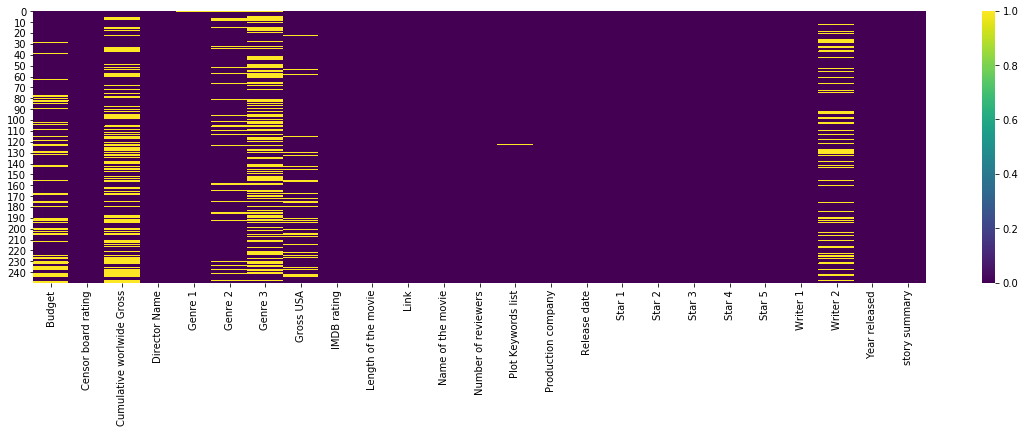

In [79]:
# identifying the null parts of the dataset :

plt.figure(figsize=(20, 5))
sns.heatmap(imdb.isnull(), cmap='viridis')

In [80]:
# Features to clean :

# 1.) Budget
# 2.) Cumulative worlwide Gross
# 3.) Gross USA
# 4.) Writer 2 (textual cleaning only)
# 5.) Censor board rating (textual cleaning only)
# 6.) Number of Reviewers (textual cleaning only)

In [81]:
# cleaning budget :

def clean_Budget(budget_value):
    
    if pd.isnull(budget_value):
        return budget_value

    else:
        budget_value = re.sub(r"\D", "", str(budget_value))
        budget_value = budget_value.strip()
        return budget_value

In [82]:
# cleaning cumulativeWorldwideGross :

def clean_cumulativeWorldwideGross(cumWorldwideGross_value):
    
    if pd.isnull(cumWorldwideGross_value):
        return cumWorldwideGross_value
    
    else:
        cumWorldwideGross_value = re.sub(r"\s\d{1,2}\s\w{1,}\s\d{4}", "", str(cumWorldwideGross_value))
        cumWorldwideGross_value = re.sub(r"\D", "", cumWorldwideGross_value)
        cumWorldwideGross_value = cumWorldwideGross_value.strip()
        return cumWorldwideGross_value

In [83]:
# cleaning grossUSA :

def clean_grossUSA(grossUSA_value):
    
    if pd.isnull(grossUSA_value):
        return grossUSA_value
    
    else:
        grossUSA_value = re.sub(r"\s\d{1,2}\s\w{1,}\s\d{4}", "", str(grossUSA_value))
        grossUSA_value = re.sub(r"\D", "", grossUSA_value)
        grossUSA_value = grossUSA_value.strip()
        return grossUSA_value

In [84]:
# cleaning Writer 2 :

def clean_writer2(writer2_value):
    writer2_value = re.sub(r"\s\d\smore\scredit\w{0,1}\s\D{1,}", "", str(writer2_value))
    writer2_value = re.sub(r"[|]", "", writer2_value)
    writer2_value = writer2_value.strip()
    return writer2_value

In [85]:
# cleaning Number of reviewers :

def clean_numOfReviewers(numOfReviewers_value):
    numOfReviewers_value = re.sub(r"\D", "", str(numOfReviewers_value))
    numOfReviewers_value = numOfReviewers_value.strip()
    return numOfReviewers_value

In [86]:
imdb['Budget'] = imdb['Budget'].apply(clean_Budget)
imdb['Cumulative worlwide Gross'] = imdb['Cumulative worlwide Gross'].apply(clean_cumulativeWorldwideGross)
imdb['Gross USA'] = imdb['Gross USA'].apply(clean_grossUSA)
imdb['Writer 2'] = imdb['Writer 2'].apply(clean_writer2)
imdb['Number of reviewers'] = imdb['Number of reviewers'].apply(clean_numOfReviewers)


# Finding means for replacement in Null/Nan values :

mean_budget = (imdb['Budget'].dropna()).astype('float').mean() 
mean_cumWorldwideGross = (imdb['Cumulative worlwide Gross'].dropna()).astype('float').mean() 
mean_grossUSA = (imdb['Gross USA'].dropna()).astype('float').mean() 

imdb['Budget'].fillna(mean_budget, inplace=True) 
imdb['Cumulative worlwide Gross'].fillna(mean_cumWorldwideGross, inplace=True) 
imdb['Gross USA'].fillna(mean_grossUSA, inplace=True)  

In [87]:
imdb['Censor board rating'].value_counts()

R    106
P     77
N     50
G     14
2      1
1      1
A      1
Name: Censor board rating, dtype: int64

In [88]:
# Censor board ratings '1' and '2', occur because movies with these censor board ratings didn't have mentioned ratings on their
# imdb web page, hence we need to replace these censor board ratings with proper rating values.

In [89]:
# Where censor board rating is '1', Genre is 'Drama' and 'Family' 

imdb[imdb['Censor board rating'] == '1']  # Genre = Drama and Family 

,Budget,Censor board rating,Cumulative worlwide Gross,Director Name,Genre 1,Genre 2,Genre 3,Gross USA,IMDB rating,Length of the movie,...,Release date,Star 1,Star 2,Star 3,Star 4,Star 5,Writer 1,Writer 2,Year released,story summary
130,3.36281e+07,1,2.74485e+08,Çagan Irmak,Drama,Family,NaN,8.41731e+07,8.2,1h 48min,...,18 November 2005 (Turkey),Çetin Tekindor,Fikret Kuskan,Hümeyra,Ege Tanman,Serif Sezer,Çagan Irmak,nan,2005,The family of a left-wing journalist is torn a...


In [90]:
# For movies with genre as drama and family, the best occuring, censor board rating is 'P'

imdb[(imdb['Genre 1']=='Drama') & (imdb['Genre 2']=='Family')] 

,Budget,Censor board rating,Cumulative worlwide Gross,Director Name,Genre 1,Genre 2,Genre 3,Gross USA,IMDB rating,Length of the movie,...,Release date,Star 1,Star 2,Star 3,Star 4,Star 5,Writer 1,Writer 2,Year released,story summary
23,3180000,P,2.74485e+08,Frank Capra,Drama,Family,Fantasy,8.41731e+07,8.6,2h 10min,...,7 January 1947 (USA),James Stewart,Donna Reed,Lionel Barrymore,Thomas Mitchell,Henry Travers,Frances Goodrich,Albert Hackett,1946,An angel is sent from Heaven to help a despera...
83,3.36281e+07,P,21897373,Aamir Khan,Drama,Family,NaN,1223869,8.3,2h 45min,...,21 December 2007 (India),Darsheel Safary,Aamir Khan,Tisca Chopra,Vipin Sharma,Sachet Engineer,Amole Gupte (dialogue & screenplay),Amole Gupte (story),2007,An eight-year-old boy is thought to be a lazy ...
128,180000,P,2.74485e+08,Majid Majidi,Drama,Family,NaN,925402,8.2,1h 29min,...,22 January 1999 (USA),Mohammad Amir Naji,Amir Farrokh Hashemian,Bahare Seddiqi,Nafise Jafar-Mohammadi,Fereshte Sarabandi,Majid Majidi,nan,1997,"After a boy loses his sister's pair of shoes, ..."
130,3.36281e+07,1,2.74485e+08,Çagan Irmak,Drama,Family,NaN,8.41731e+07,8.2,1h 48min,...,18 November 2005 (Turkey),Çetin Tekindor,Fikret Kuskan,Hümeyra,Ege Tanman,Serif Sezer,Çagan Irmak,nan,2005,The family of a left-wing journalist is torn a...
208,16000000,G,47707417,Lasse Hallström,Drama,Family,NaN,8.41731e+07,8.1,1h 33min,...,12 March 2010 (UK),Richard Gere,Joan Allen,Cary-Hiroyuki Tagawa,Sarah Roemer,Jason Alexander,Stephen P. Lindsey (screenplay),"Kaneto Shindô (motion picture ""Hachiko monogat...",2009,A college professor's bond with the abandoned ...


In [91]:
# For where censor board rating '1', we replace this rating with 'P' :

imdb.loc[imdb['Censor board rating']=='1', 'Censor board rating'] = 'P' 

In [92]:
# Where censor board rating is '2', Genre is 'Crime' and 'Drama' and 'Thriller'  : 

imdb[imdb['Censor board rating'] == '2']  # Genre = Crime and Drama and Thriller

,Budget,Censor board rating,Cumulative worlwide Gross,Director Name,Genre 1,Genre 2,Genre 3,Gross USA,IMDB rating,Length of the movie,...,Release date,Star 1,Star 2,Star 3,Star 4,Star 5,Writer 1,Writer 2,Year released,story summary
191,3.36281e+07,2,1979000,Yavuz Turgul,Crime,Drama,Thriller,8.41731e+07,8.1,2h 8min,...,29 November 1996 (Turkey),Sener Sen,Ugur Yücel,Sermin Hürmeriç,Yesim Salkim,Kamran Usluer,Yavuz Turgul,nan,1996,"Baran the Bandit, released from prison after 3..."


In [93]:
# For movies with genre as Crime and Drama and Thriller, the best occuring, censor board rating is 'R'

# imdb[(imdb['Genre 1']=='Crime') & (imdb['Genre 2']=='Drama')]  # max occuring rating is 'R'
# imdb[(imdb['Genre 1']=='Drama') & (imdb['Genre 2']=='Thriller')]  # max occuring rating is 'R'
# imdb[(imdb['Genre 1']=='Crime') & (imdb['Genre 2']=='Thriller')] # only one case and that too with rating = 'P'

In [94]:
# Allocating the best possible censor board ratings for movies with 'Censor board rating' as '1' and '2':

imdb.loc[imdb['Censor board rating']=='2', 'Censor board rating'] = 'R'

# 1.2) Preprocessing : 

In [95]:
# Adjusting the datatypes of the model relevant features :

imdb['Budget'] = imdb['Budget'].astype('float')
imdb['Cumulative worlwide Gross'] = imdb['Cumulative worlwide Gross'].astype('float')
imdb['Gross USA'] = imdb['Gross USA'].astype('float')
imdb['IMDB rating'] = imdb['IMDB rating'].astype('float')
imdb['Number of reviewers'] = imdb['Number of reviewers'].astype('int')

In [96]:
imdb.dtypes

Budget                       float64
Censor board rating           object
Cumulative worlwide Gross    float64
Director Name                 object
Genre 1                       object
Genre 2                       object
Genre 3                       object
Gross USA                    float64
IMDB rating                  float64
Length of the movie           object
Link                          object
Name of the movie             object
Number of reviewers            int32
Plot Keywords list            object
Production company            object
Release date                  object
Star 1                        object
Star 2                        object
Star 3                        object
Star 4                        object
Star 5                        object
Writer 1                      object
Writer 2                      object
Year released                  int64
story summary                 object
dtype: object

In [97]:
# Genres will be an important feature for model building, hence collating all genres available in the dataset :

gen1 = list(set(list(imdb['Genre 1'])))
gen2 = list(set(list(imdb['Genre 2'])))
gen3 = list(set(list(imdb['Genre 3'])))

all_genres = list(set(gen1 + gen2 + gen3))
all_genres.pop(0)  # removing 'nan' from the list of all genres
all_genres

['Biography',
 'Family',
 'Romance',
 'Thriller',
 'Adventure',
 'Fantasy',
 'Music',
 'Crime',
 'War',
 'Comedy',
 'Film-Noir',
 'Sport',
 'Musical',
 'Mystery',
 'Horror',
 'Action',
 'Western',
 'Animation',
 'History',
 'Drama',
 'Sci-Fi']

In [98]:
# Encoding the above genres as dataset features :

# 1 for presence and 
# 0 for absence

for each_genre in all_genres :
    imdb[each_genre] = (imdb['Genre 1'] == each_genre)*1 + (imdb['Genre 2'] == each_genre)*1 + (imdb['Genre 3'] == each_genre)*1 

In [99]:
# Encoding the above 'censor board rating' as dataset feature :

# 1 for presence and 
# 0 for absence

for each_rating_type in set(list(imdb['Censor board rating'])):
    imdb[str(each_rating_type)] = (imdb['Censor board rating'] == str(each_rating_type))*1

In [113]:
imdb.head(2)

,Budget,Censor board rating,Cumulative worlwide Gross,Director Name,Genre 1,Genre 2,Genre 3,Gross USA,IMDB rating,Length of the movie,...,Western,Animation,History,Drama,Sci-Fi,A,N,G,R,P
0,25000000.0,R,58500000.0,Frank Darabont,Drama,NaN,NaN,28341469.0,9.2,2h 22min,...,0,0,0,1,0,0,0,0,1,0
1,6000000.0,R,245066411.0,Francis Ford Coppola,NaN,NaN,NaN,134966411.0,9.2,2h 55min,...,0,0,0,0,0,0,0,0,1,0


# ASSIGNMENT - 2 :

# 1 ) Model Building :

In [100]:
imdb.columns

Index(['Budget', 'Censor board rating', 'Cumulative worlwide Gross',
       'Director Name', 'Genre 1', 'Genre 2', 'Genre 3', 'Gross USA',
       'IMDB rating', 'Length of the movie', 'Link', 'Name of the movie',
       'Number of reviewers', 'Plot Keywords list', 'Production company',
       'Release date', 'Star 1', 'Star 2', 'Star 3', 'Star 4', 'Star 5',
       'Writer 1', 'Writer 2', 'Year released', 'story summary', 'Biography',
       'Family', 'Romance', 'Thriller', 'Adventure', 'Fantasy', 'Music',
       'Crime', 'War', 'Comedy', 'Film-Noir', 'Sport', 'Musical', 'Mystery',
       'Horror', 'Action', 'Western', 'Animation', 'History', 'Drama',
       'Sci-Fi', 'A', 'N', 'G', 'R', 'P'],
      dtype='object')

In [101]:
# pd.DataFrame(data=imdb.columns)

X = imdb.iloc[:, [0,2,7,12,25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,42, 43, 44, 45, 46, 47, 48, 49, 50]].values 
y = imdb.iloc[:, 8].values

In [102]:
# Splitting into train and test set :
# 80 % train set
# 20 % test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [103]:
# Since models such as decision tree regressor and SVR tend to overfit on small amounts of data, 
# hence we prefer Linear Regression model :

# Linear Regression model :

linearRegressionModel = LinearRegression()
linearRegressionModel.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [104]:
# Predicting the ratings by the model :

y_predicted = linearRegressionModel.predict(X_test)

In [105]:
# Evaluating the model :

print("Mean absolute error {}".format(mean_absolute_error(y_test, y_predicted)))
print("Mean squared error {}".format(mean_squared_error(y_test, y_predicted)))
print("R2 score {}".format(r2_score(y_test, y_predicted)))
print("Mean absolute percentage error {} %".format(np.mean(np.abs((y_test - y_predicted) / y_test)) * 100))

Mean absolute error 0.1480348316870707
Mean squared error 0.033107805620791846
R2 score 0.231908741165743
Mean absolute percentage error 1.7922317711348164 %


In [106]:
# Cross validating the model :

cross_validation = cross_val_score(estimator=linearRegressionModel,
                                   X=X_train,
                                   y=y_train,
                                   scoring='neg_mean_absolute_error',
                                   cv=10,
                                   n_jobs=-1)

In [107]:
# Obtaining negative mean absolute error in the 10 step validation :

# Errors obtained :

print("Errors obtained {}".format(cross_validation*-1))
print("\nMinimum error obsereved {}".format((cross_validation*-1).min()))
print("Maximum error obsereved {}".format((cross_validation*-1).max()))
print("Mean error observation {}".format((cross_validation*-1).mean()))
print("Standard deviation in observed errors {}".format((cross_validation*-1).std()))

Errors obtained [0.15012345 0.1553707  0.16494434 0.14207045 0.14710395 0.13486998
 0.1444983  0.1287772  0.1260268  0.10679778]

Minimum error obsereved 0.10679777860672504
Maximum error obsereved 0.16494433939095918
Mean error observation 0.14005829531040165
Standard deviation in observed errors 0.015766491423610283


In [108]:
# Conclusion :

# Hence our model seems to perform at optimum, with neither too much overfitting or underfitting, 
# maintaining optimal bias-variance tradeoff.